In [1]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import xarray as xr

In [2]:
input_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/classification_16.tif'
output_dir = '/scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/'

reference_grid_path = "/scratch/project_2000908/nousu/mNFI_to_NEP/METEO/AVGS/air_temperature.tif"
output_reprojected_dir = '/scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/'

os.makedirs(output_reprojected_dir, exist_ok=True)
with rasterio.open(reference_grid_path) as ref:
    target_crs = ref.crs
    target_transform = ref.transform
    target_width = ref.width
    target_height = ref.height
    ref_nodata = ref.nodata if ref.nodata is not None else np.nan

In [3]:
block_size = int(10000 / 16)  # 625 pixels = 10 km at 16 m resolution
classes = range(1, 13)        # Classes 1 to 12
nodata_value = -9999              # Assuming -9999 means no data

os.makedirs(output_dir, exist_ok=True)

# Read input raster
with rasterio.open(input_file) as src:
    data = src.read(1).astype(np.float32)
    transform = src.transform
    crs = src.crs
    dtype = np.float32  # For output fractions

# Mask nodata
data[data == nodata_value] = np.nan

# Crop to full blocks
h, w = data.shape
h_crop = (h // block_size) * block_size
w_crop = (w // block_size) * block_size
data = data[:h_crop, :w_crop]

# Reshape to blocks (rows, block_h, cols, block_w)
data_blocks = data.reshape(
    h_crop // block_size, block_size,
    w_crop // block_size, block_size
)
# Move axes to (rows, cols, block_h, block_w)
data_blocks = np.moveaxis(data_blocks, 2, 1)

# Compute total count of valid pixels per block
valid_counts = np.sum(~np.isnan(data_blocks), axis=(2, 3))

# Compute fractions for each class
for k in classes:
    print(f"Processing class {k}")
    
    # Create binary mask for current class
    class_mask = np.where(data_blocks == k, 1.0, 0.0)
    class_mask[np.isnan(data_blocks)] = np.nan  # Respect NaNs in input
    
    # Sum class counts in each block
    class_counts = np.nansum(class_mask, axis=(2, 3))
    
    # Compute fraction (class count / total valid count)
    class_fraction = class_counts / valid_counts
    class_fraction[valid_counts == 0] = np.nan  # Mask blocks with no valid data

    # Create new transform
    new_transform = rasterio.Affine(
        transform.a * block_size, 0, transform.c,
        0, transform.e * block_size, transform.f
    )

    # Output file path
    out_path = os.path.join(output_dir, f'class_{k}.tif')

    # Write to raster
    with rasterio.open(
        out_path, 'w',
        driver='GTiff',
        height=class_fraction.shape[0],
        width=class_fraction.shape[1],
        count=1,
        dtype=dtype,
        crs=crs,
        transform=new_transform,
        nodata=np.nan
    ) as dst:
        dst.write(class_fraction, 1)

    print(f"Saved: {out_path}")
    
    # Reproject to match reference raster
    reprojected_output_path = os.path.join(output_reprojected_dir, f'class_{k}.tif')
    
    with rasterio.open(out_path) as src:
        src_array = src.read(1)
        src_transform = src.transform
        src_crs = src.crs
    
        reprojected_array = np.full((target_height, target_width), np.nan, dtype=np.float32)
    
        reproject(
            source=src_array,
            destination=reprojected_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
            src_nodata=np.nan,
            dst_nodata=np.nan
        )
    
        with rasterio.open(
            reprojected_output_path,
            'w',
            driver='GTiff',
            height=target_height,
            width=target_width,
            count=1,
            dtype=np.float32,
            crs=target_crs,
            transform=target_transform,
            nodata=np.nan
        ) as dst:
            dst.write(reprojected_array, 1)
    
    print(f"Reprojected saved to: {reprojected_output_path}")

print("Done.")

Processing class 1
Saved: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/class_1.tif
Reprojected saved to: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/class_1.tif
Processing class 2
Saved: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/class_2.tif
Reprojected saved to: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/class_2.tif
Processing class 3
Saved: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/class_3.tif
Reprojected saved to: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/class_3.tif
Processing class 4
Saved: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/class_4.tif
Reprojected saved to: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/class_4.tif
Processing class 5
Saved: /scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km/class_5.ti

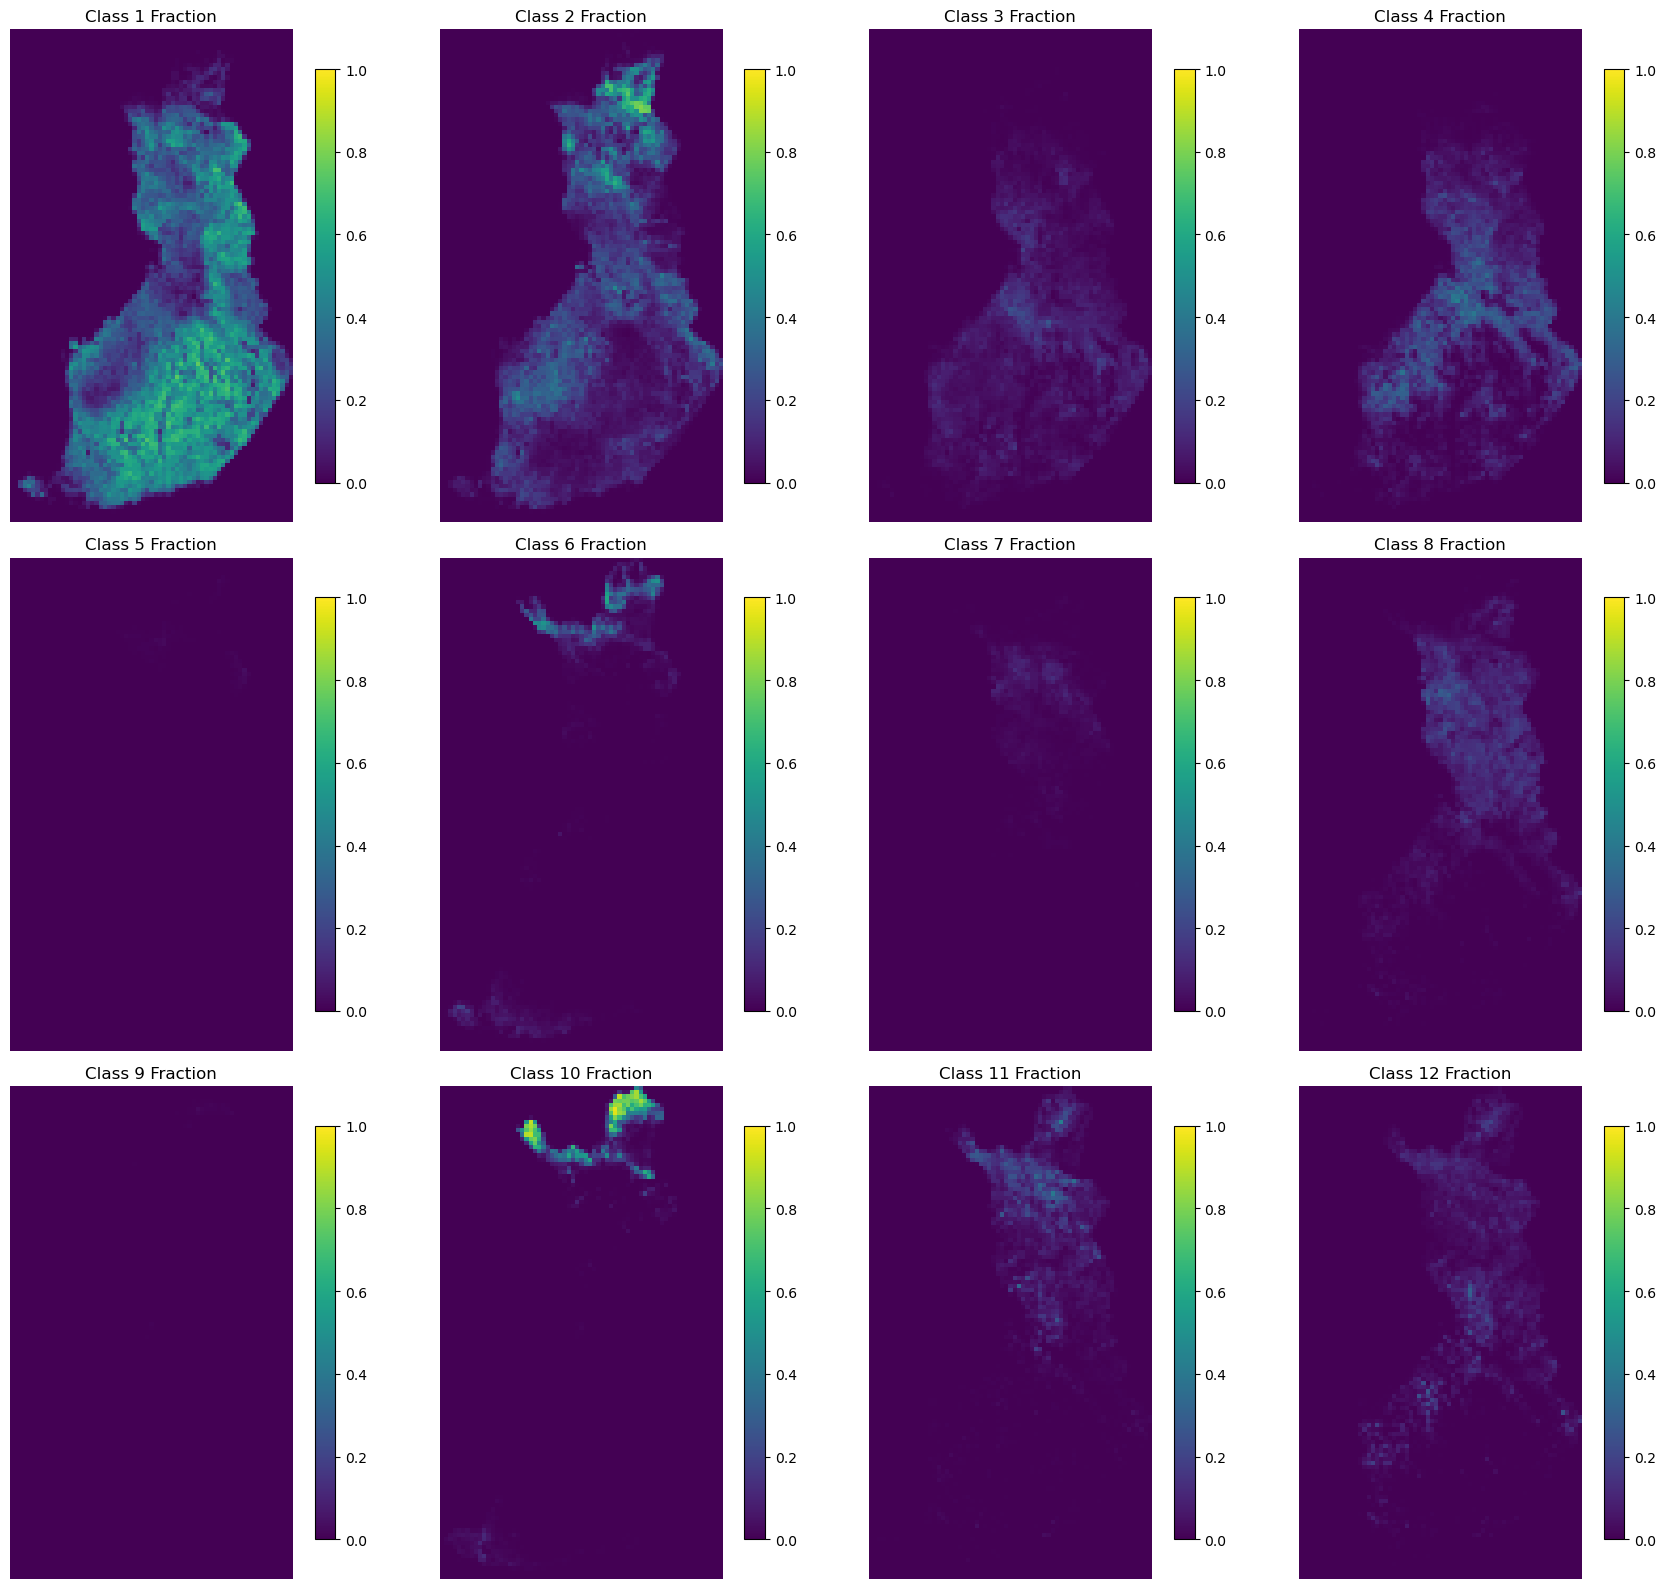

In [6]:
# Input directory and class info
fraction_dir = '/scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_10x10km'
classes = range(1, 13)

# Storage for all fraction arrays
fractions = []

# Read each class fraction raster
for k in classes:
    file_path = os.path.join(fraction_dir, f'class_{k}.tif')
    with rasterio.open(file_path) as src:
        data = src.read(1)
        fractions.append(data)

# Convert to 3D array: (class, row, col)
fractions = np.array(fractions)

# Compute the sum across all classes
fraction_sum = np.nansum(fractions, axis=0)

# Plot
fig, axes = plt.subplots(3, 4, figsize=(18, 16))
axes = axes.ravel()

# Plot each class fraction
for i, k in enumerate(classes):
    ax = axes[i]
    im = ax.imshow(fractions[i], cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Class {k} Fraction')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046)

## Plot the sum of all class fractions
#ax = axes[-1]
#im = ax.imshow(fraction_sum, cmap='plasma')
#ax.set_title('Sum of All Class Fractions')
#ax.axis('off')
#fig.colorbar(im, ax=ax, fraction=0.046)

# Hide any extra subplots
for j in range(len(classes) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Paths
input_dir = '/scratch/project_2000908/nousu/mNFI_to_NEP/MNFI/class_fractions_reproj_10x10km/'
output_nc_file = "/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/class_fractions.nc"

# Get all .tif files
tif_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".tif")])

# Initialize storage
data_vars = {}
coords = {}

# Read and process rasters
for i, fname in enumerate(tif_files):
    varname = os.path.splitext(fname)[0]  # Variable name from filename
    path = os.path.join(input_dir, fname)

    with rasterio.open(path) as src:
        data = src.read(1)
        nodata = src.nodata
        data = np.where(data == nodata, np.nan, data)

        # Only read coordinates once
        if i == 0:
            height, width = data.shape
            transform = src.transform
            x_coords = transform.c + transform.a * np.arange(width)
            y_coords = transform.f + transform.e * np.arange(height)
            coords["x"] = x_coords
            coords["y"] = y_coords[::-1]  # reverse Y axis for north-up

        # Add flipped data to ensure coordinate match
        data_vars[varname] = (("y", "x"), np.flipud(data))

# Create Dataset
ds = xr.Dataset(data_vars=data_vars, coords=coords)

# Add global metadata description
#ds.attrs["description"] = (
#    "mNFI variable names follow the pattern 'ika_X_Y_Z':\n"
#    " - X (1-3): land class (1 = forest, 2 = other wooded land, 3 = other land)\n"
#    " - Y (1 or 2): site main class (1 = mineral, 2 = peat)\n"
#    " - Z (1 or 2): site fertility  (1 = rich, 2 = poor)"
#)

# Save to NetCDF
ds.to_netcdf(output_nc_file)
ds.close()

print(f"Saved NetCDF to: {output_nc_file}")

Saved NetCDF to: /scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/class_fractions.nc


In [3]:
file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/class_fractions.nc'
data = xr.open_dataset(file)